Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [2]:
import sys
sys.prefix

'/home/mabelvj/tensorflow'

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pickle_file = 'exploration.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 32, 32) (8432,)
Validation set (2811, 32, 32) (2811,)
Test set (2811, 32, 32) (2811,)


In [5]:
image_height = 32
image_width = 32
num_labels = 2

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_width * image_height)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 1024) (8432, 2)
Validation set (2811, 1024) (2811, 2)
Test set (2811, 1024) (2811, 2)


In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [31]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 8000
num_steps= 0


graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  randomized_dataset, randomized_labels = randomize( train_dataset, train_labels)
  tf_train_dataset = tf.constant(randomized_dataset[:train_subset, :]) # still one dimension
  tf_train_labels = tf.constant(randomized_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_height * image_width, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  #decaying learning rate:
  starting_learning_rate = 0.0001
  learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 5001, 0.9, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  
    
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [36]:
#num_steps = 501
#num_steps = train_dataset.shape[0] // batch_size

num_steps = 3001
print ("num_steps:%d" %num_steps)

valid_accuracy = []
valid_auc = []
test_accuracy = []
test_auc = []
pred_step = []
from sklearn.metrics import roc_auc_score


with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 250 == 0):
      print('Loss at step %d: %f' % (step, l))

      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))

      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
      print('AUC: %.3f' %  roc_auc_score(valid_labels, valid_prediction.eval()))
      print (".................")
        
    if (step % 150 == 0):
        valid_accuracy.append(accuracy(
                valid_prediction.eval(), valid_labels))
        valid_auc.append(roc_auc_score(valid_labels, valid_prediction.eval()))
        test_accuracy.append(accuracy(
                test_prediction.eval(), test_labels))
        test_auc.append(roc_auc_score(test_labels, test_prediction.eval()))
        pred_step.append(step)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  print('Test AUC ROC: %.3f' %  roc_auc_score(test_labels, test_prediction.eval())) 

num_steps:3001
Initialized
Loss at step 0: 1094.954468
Training accuracy: 50.1%
Validation accuracy: 42.4%
AUC: 0.424
.................
Loss at step 250: 453.246674
Training accuracy: 50.2%
Validation accuracy: 67.1%
AUC: 0.673
.................
Loss at step 500: 355.413696
Training accuracy: 49.8%
Validation accuracy: 72.9%
AUC: 0.733
.................
Loss at step 750: 315.018738
Training accuracy: 49.7%
Validation accuracy: 75.3%
AUC: 0.759
.................
Loss at step 1000: 290.131134
Training accuracy: 49.9%
Validation accuracy: 76.8%
AUC: 0.773
.................
Loss at step 1250: 271.531250
Training accuracy: 50.0%
Validation accuracy: 77.2%
AUC: 0.778
.................
Loss at step 1500: 256.387909
Training accuracy: 50.0%
Validation accuracy: 77.7%
AUC: 0.782
.................
Loss at step 1750: 243.455154
Training accuracy: 50.0%
Validation accuracy: 78.1%
AUC: 0.786
.................
Loss at step 2000: 232.114594
Training accuracy: 50.0%
Validation accuracy: 78.2%
AUC: 0.7

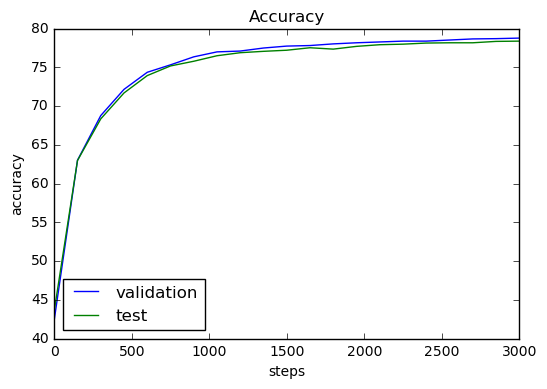

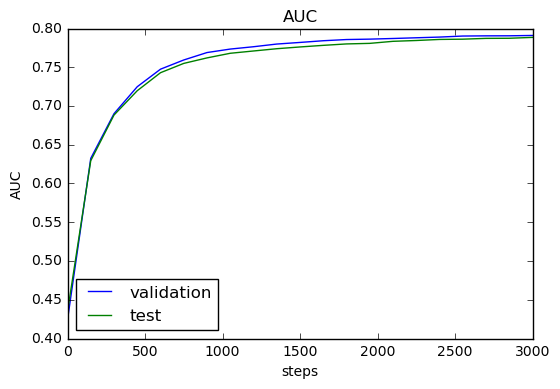

In [37]:
%matplotlib inline 
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend(loc= "best")
plt.title ("Accuracy")
plt.show()

plt.plot(pred_step,valid_auc, label= 'validation')
plt.plot(pred_step,test_auc, label= 'test')
plt.xlabel('steps')
plt.ylabel('AUC')
plt.legend(loc= "best")
plt.title ("AUC")
plt.show()



## Stochastic gradient descent
Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [19]:
batch_size = 10
num_steps = 0



Let's run it:

In [131]:
batch_size_array = [5, 10, 15]
lr = [1e-5, 1e-4, 5e-4]
valid_accuracy_array = []
valid_auc_array = []
test_accuracy_array = []
test_auc_array = []
pred_step_array = []
from sklearn.metrics import roc_auc_score

for i, batch_size in enumerate(batch_size_array):
        
    print ("batch size:%d \n"%batch_size)
    num_steps = train_dataset.shape[0] // batch_size
    print ("num_steps:%d" %num_steps)

    valid_accuracy = []
    valid_auc = []
    test_accuracy = []
    test_auc = []
    pred_step = []

    graph = tf.Graph()
    with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_width * image_height))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # Variables.
      weights = tf.Variable(
        tf.truncated_normal([image_width * image_height, num_labels]))
      biases = tf.Variable(tf.zeros([num_labels]))

      # Training computation.
      logits = tf.matmul(tf_train_dataset, weights) + biases
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

      # Optimizer.
      # We are going to find the minimum of this loss using gradient descent.
      #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
      #decaying learning rate:
      
      starting_learning_rate = lr[i]
      learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, num_steps*0.75,
                                                 0.75, staircase=True)
      optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
      test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    
  
    

    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        #batch_data = train_dataset[offset:(offset + batch_size), :]
        #batch_labels = train_labels[offset:(offset + batch_size), :]
        batch_data, batch_labels = randomize(
            train_dataset[offset:(offset + batch_size), :],  train_labels[offset:(offset + batch_size), :])
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
          valid_accuracy.append(accuracy(
                valid_prediction.eval(), valid_labels))
          valid_auc.append(roc_auc_score(valid_labels, valid_prediction.eval()))
          test_accuracy.append(accuracy(
                test_prediction.eval(), test_labels))
          test_auc.append(roc_auc_score(test_labels, test_prediction.eval()))
          pred_step.append(step)
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
      valid_accuracy_array.append(valid_accuracy)
      valid_auc_array.append(valid_auc)
      test_accuracy_array.append(test_accuracy)
      test_auc_array.append(test_auc)
      pred_step_array.append(pred_step)
      print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
      print('Test AUC ROC: %.3f' %  roc_auc_score(test_labels, test_prediction.eval())) 
      print("-----------------------------------------\n")

batch size:5 

num_steps:1686
Initialized
Minibatch loss at step 0: 2515.860596
Minibatch accuracy: 60.0%
Validation accuracy: 50.2%
Minibatch loss at step 100: 2049.219727
Minibatch accuracy: 60.0%
Validation accuracy: 50.0%
Minibatch loss at step 200: 443.845459
Minibatch accuracy: 60.0%
Validation accuracy: 49.2%
Minibatch loss at step 300: 867.277954
Minibatch accuracy: 60.0%
Validation accuracy: 48.2%
Minibatch loss at step 400: 630.011475
Minibatch accuracy: 20.0%
Validation accuracy: 48.6%
Minibatch loss at step 500: 578.139771
Minibatch accuracy: 80.0%
Validation accuracy: 49.8%
Minibatch loss at step 600: 575.995422
Minibatch accuracy: 80.0%
Validation accuracy: 50.5%
Minibatch loss at step 700: 694.829224
Minibatch accuracy: 60.0%
Validation accuracy: 52.0%
Minibatch loss at step 800: 814.813965
Minibatch accuracy: 60.0%
Validation accuracy: 53.9%
Minibatch loss at step 900: 437.166901
Minibatch accuracy: 80.0%
Validation accuracy: 55.0%
Minibatch loss at step 1000: 364.76986

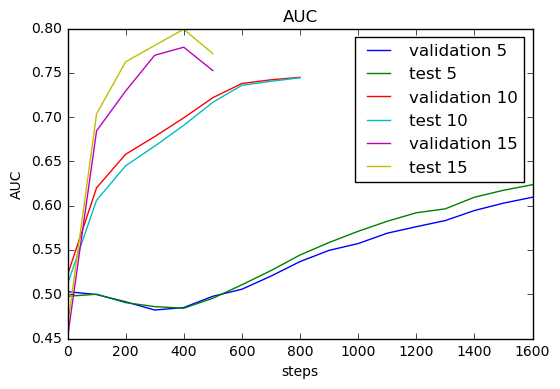

In [133]:
for i in range(len(pred_step_array)):
    plt.plot(pred_step_array[i],valid_auc_array[i], label= 'validation %d'%batch_size_array[i])
    plt.plot(pred_step_array[i],test_auc_array[i], label= 'test %d'%batch_size_array[i])
plt.xlabel('steps')
plt.ylabel('AUC')
plt.legend(loc= "best")
plt.title ("AUC")
plt.show()



---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [18]:
batch_size = 500
hidden_nodes= 512
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

    # Variables.
  weights1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([ hidden_nodes]))
  weights2 = tf.Variable(tf.truncated_normal([hidden_nodes,num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
   
  def forward_prop(inp):
        h1 = tf.nn.relu(tf.matmul(inp, weights1)+biases1)
        return tf.matmul(h1,weights2) + biases2
    
  # Training computation.
  logits = forward_prop(tf_train_dataset)
    
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [24]:
def randomize_linear(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [27]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.

    X_batch, Y_batch = randomize_linear(
        train_dataset,  train_labels)    
    batch_data = X_batch[offset:(offset + batch_size), :]
    batch_labels = Y_batch[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 519.659302
Minibatch accuracy: 48.2%
Validation accuracy: 74.7%
Minibatch loss at step 500: 0.597418
Minibatch accuracy: 63.0%
Validation accuracy: 62.1%
Minibatch loss at step 1000: 0.537874
Minibatch accuracy: 67.4%
Validation accuracy: 65.0%
Minibatch loss at step 1500: 0.496857
Minibatch accuracy: 70.0%
Validation accuracy: 68.4%
Minibatch loss at step 2000: 0.464113
Minibatch accuracy: 73.4%
Validation accuracy: 69.7%
Minibatch loss at step 2500: 0.435398
Minibatch accuracy: 79.0%
Validation accuracy: 70.5%
Minibatch loss at step 3000: 0.437727
Minibatch accuracy: 75.4%
Validation accuracy: 71.7%
Test accuracy: 72.1%


In [ ]:
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()